In [1]:
import pandas as pd
import numpy as np

import visions as v
from visions.typesets import CompleteSet
from visions.functional import infer_type, cast_to_inferred, compare_detect_inference_frame
%matplotlib inline

# The Basics

`visions` is a library for deterministic evaluation of semantic data types. Under normal conditions, particularly when working with unprocessed data, the *type* of a series is defined by it's physical representation in memory, so although it's trivially obvious to a practitioner that the sequence [1.0, 2.0, 3.0] *should* be integer, to the machine those are all floats. Here we will demonstrate how you can use visions to easily infer the semantic representations of your data for this and other more complicated data types.

In [2]:
# Load dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Plotting

If you don't already have gcc compiled you might need to install pygraphviz directly. Visions relies upon pygraphviz to visualize the relationship graph constructed between types.

Let's make sure pygraphviz is installed so that

In [3]:
!conda install pygraphviz -y

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.



PackagesNotFoundError: The following packages are not available from current channels:

  - pygraphviz

Current channels:

  - https://conda.anaconda.org/conda-forge/win-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




# `visions` Building Blocks

Within `visions` there are two main ideas we need to get started. 

### Types

The first is, unsurprisingly, a `Type`. Think of these as literally the semantic meaning of a sequence. A `String` type represents the type for all sequences of exclusively strings (and the missing value indicator np.nan), a `DateTime` type the type for all sequences of Timestamps or Datetimes, and so on. 


### Typesets

The second is the `Typeset`, which represents a collection of types. Now that we've moved beyond the realm of physical types it's possible to imagine conflicting notions of a sequences data type. For example, some users might be interested in probabilities defined as any sequence of numbers between 0 and 1 while others might instead consider them bound between 0 and 100. In order to resolve this conflict, users can encapsulate their preferred types into a single object, the `Typeset`. So long as each type follows a few simple rules, `visions` will automatically determine the relationships between types to construct a traversible relationship graph between each. 

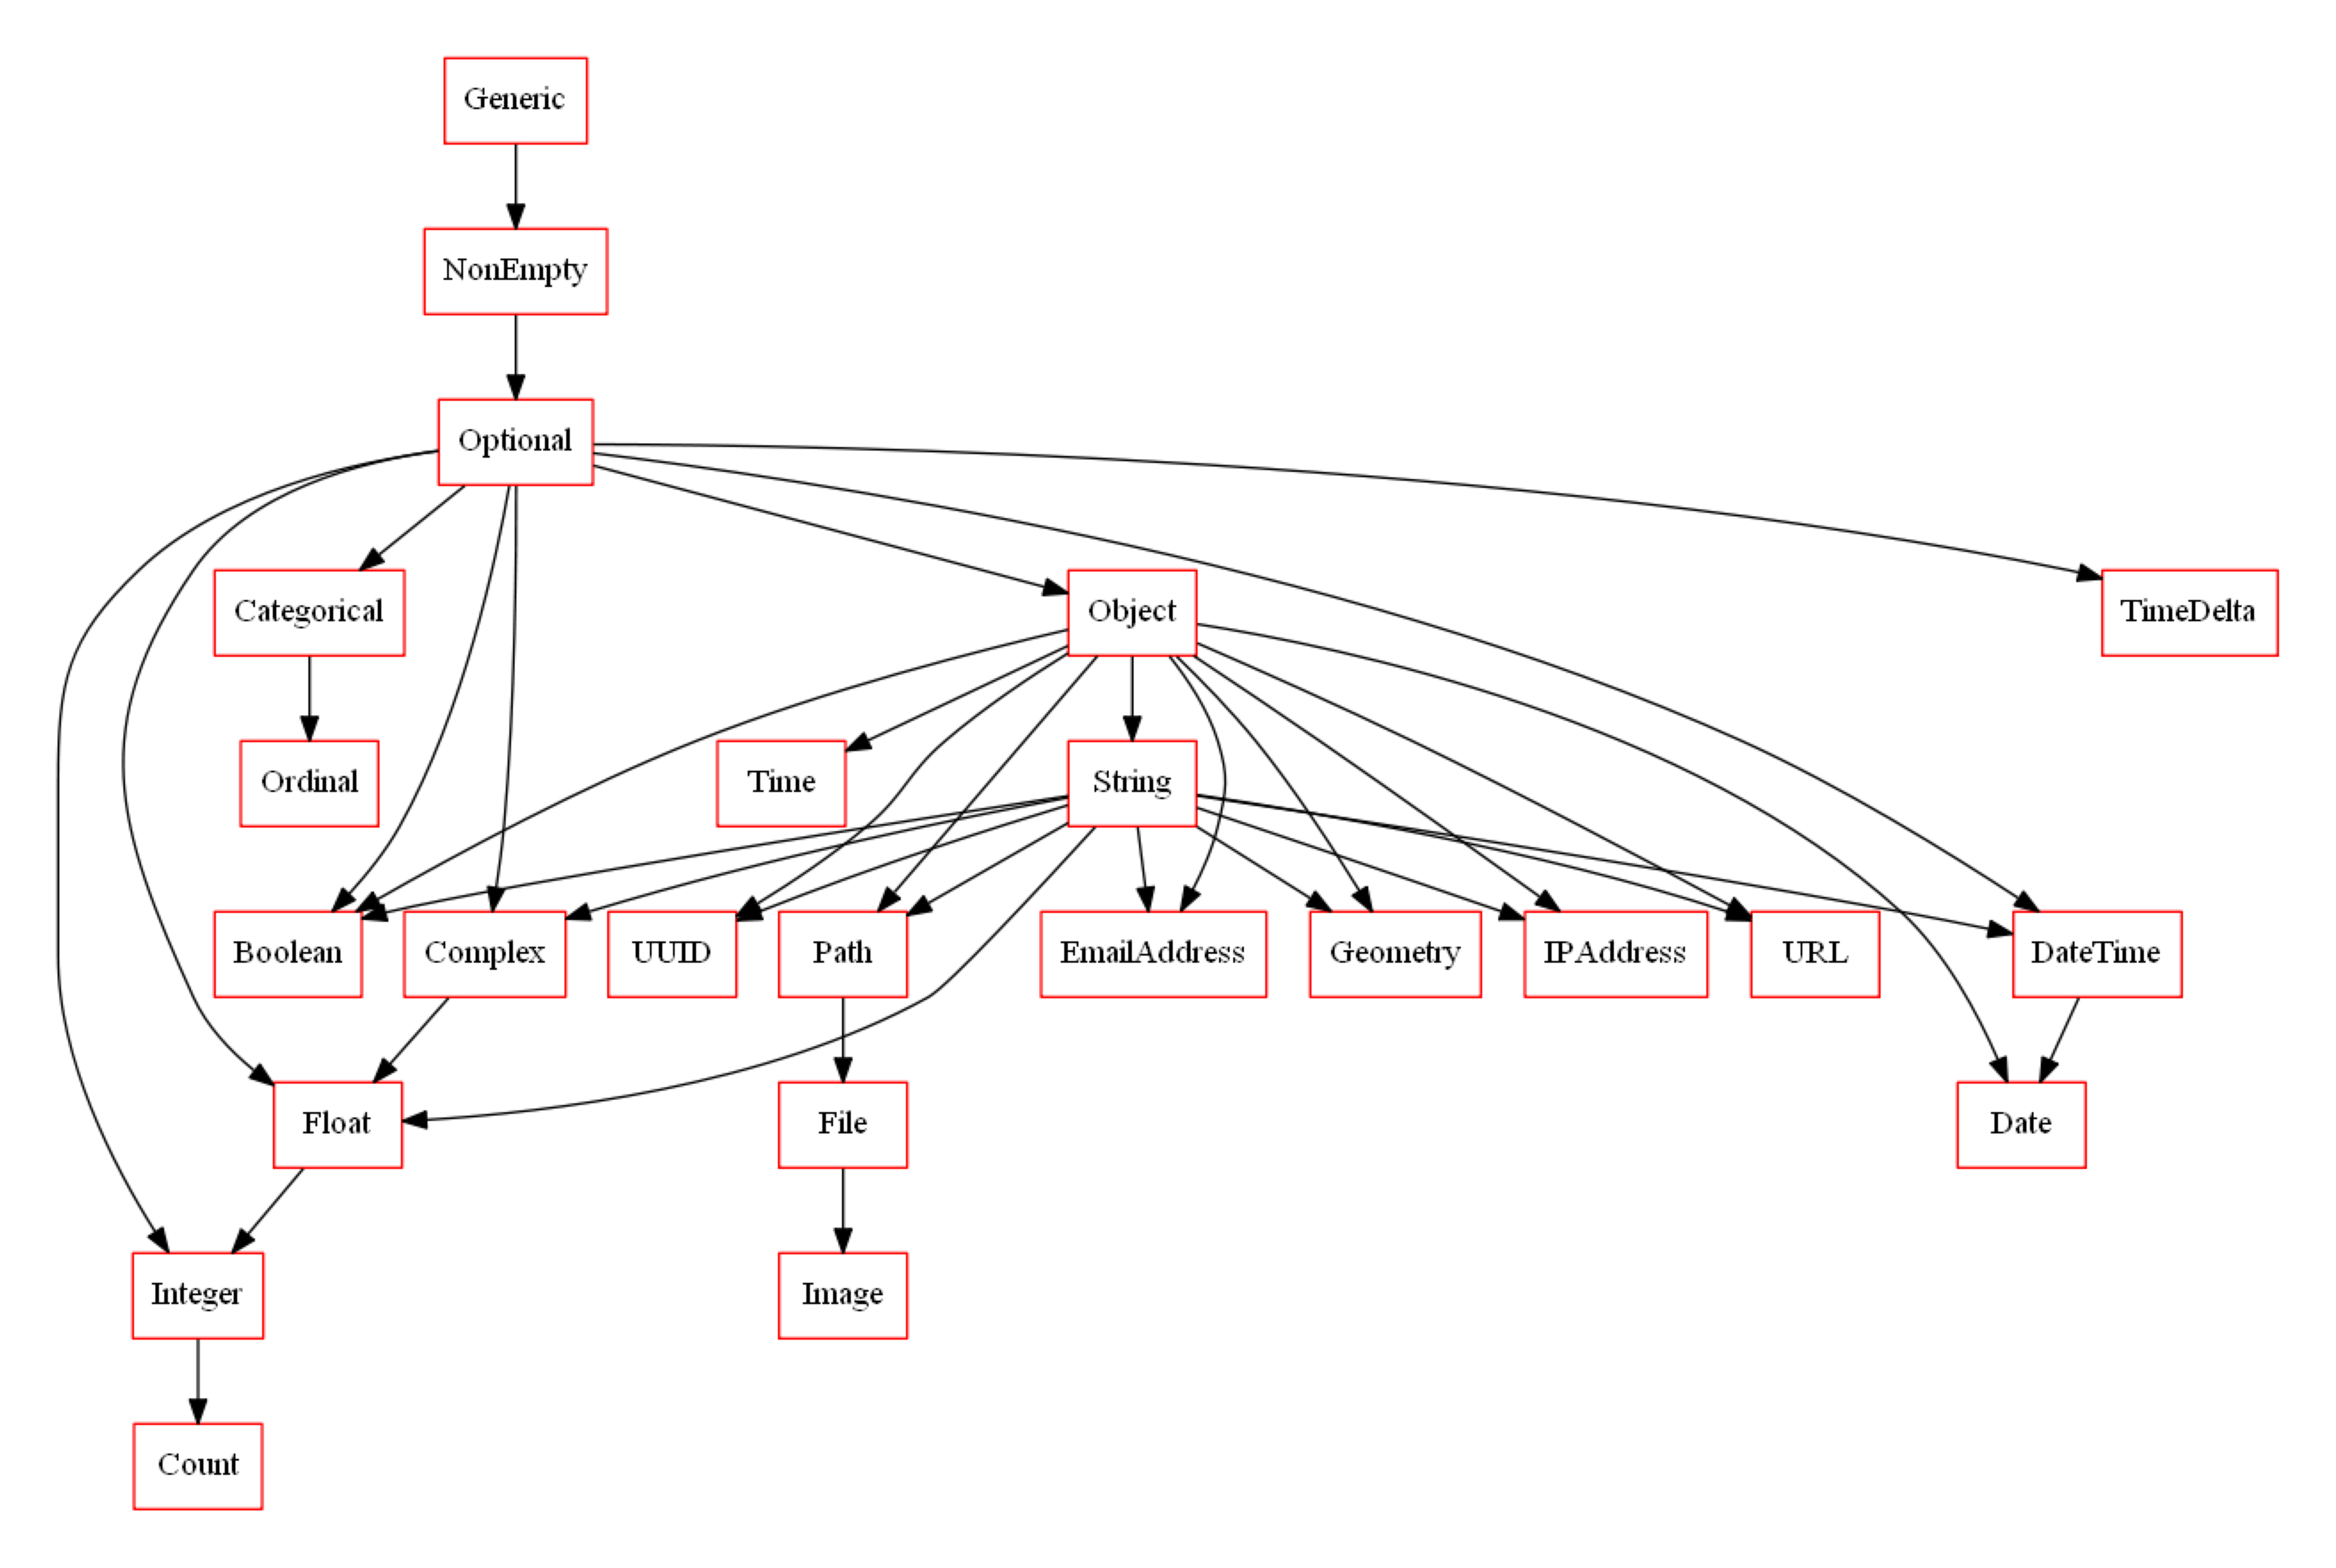

In [5]:
typeset = CompleteSet()
typeset.plot_graph()

# Using a Typeset

Now that we have the basic building blocks down, let's start using our typeset. Our first task is to see visions type inference capabilities in action. In order to make the problem a little more interesting let's also convert all of our data to strings and see what visions does.

In [6]:
inferred_types = compare_detect_inference_frame(df.astype(str), typeset)
pd.DataFrame({name: [data[i] for data in inferred_types] 
              for i, name in enumerate(['Columns', 'OriginalType', 'Inferredtype'])})

,Columns,OriginalType,Inferredtype
0,Sex,String,String
1,Cabin,String,String
2,SibSp,String,Integer
3,Parch,String,Integer
4,PassengerId,String,Integer
5,Pclass,String,Integer
6,Age,String,Float
7,Ticket,String,String
8,Name,String,String
9,Fare,String,Float


Great, as we can see, `visions` is able to exploit the relationships instrinsic to a `Typeset` to infer the semantic types of our data regardless of it's initial physical representation.

We can go a little further though and have visions *losslessly* coerce our data into it's most semantically meaningful representation without our lifting a finger.

In [7]:
cast_df = cast_to_inferred(df, typeset)
cast_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
cast_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

As an aside, utilities like `cast` from visions [functional API](https://dylan-profiler.github.io/visions/visions/api/typesets.html#functional-api) are simple redirections of an [object oriented API](https://dylan-profiler.github.io/visions/visions/api/_autosummary/visions.typesets.VisionsTypeset.html) defined on the typeset. Feel free to use whichever is most appealing to your personal style.

# Custom Typing

This is all well and good but often we are interested in defining our own custom semantic associations with our data whether as part of an EDA pipeline, a data validation test, or something else altogether and with `visions` defining those types is easy.

Let's create a `BiologicalSex` type corresponding to the same field in our data which has only two unique values: `male` and `female`.

In [9]:
from visions.types import VisionsBaseType


class BiologicalSex(VisionsBaseType):
    @classmethod
    def contains_op(cls, series):
        return series.isin({'male', 'female'}).all()
    
    @classmethod
    def get_relations(cls):
        return []

As we can see, defining a new type is easy, requiring only two methods: `contains_op` and `get_relations`. The contains op is a test to determine whether a provided series is of the semantic type represented by the class. In this case, is the data comprised exclusively of the strings `male` and `female`.

This simple definition builds a friendly API to work with data. For example, if we wanted to determine whether a sequence was of the type `BiologicalSex` we can do the following

In [ ]:
# todo: note that always update typeset
new_typeset = typeset + BiologicalSex
# this line below shouldn't be needed
BiologicalSex.typeset = new_typeset

In [13]:
df.Sex in BiologicalSex

False

In [14]:
df.Age in BiologicalSex

False

What about `get_relations` though? This method allows us to create relationships between other semantic data types. In this case, our definition of BiologicalSex assumes that all data is a `String` so let's now define a relationship between the two and create a new typeset with BiologicalSex.

In [16]:
from visions.relations import IdentityRelation, InferenceRelation
from visions.types import String

class BiologicalSex(VisionsBaseType):
    @classmethod
    def contains_op(cls, series):
        return series.isin({'male', 'female'}).all()
    
    @classmethod
    def get_relations(cls):
        return [IdentityRelation(cls, String)]

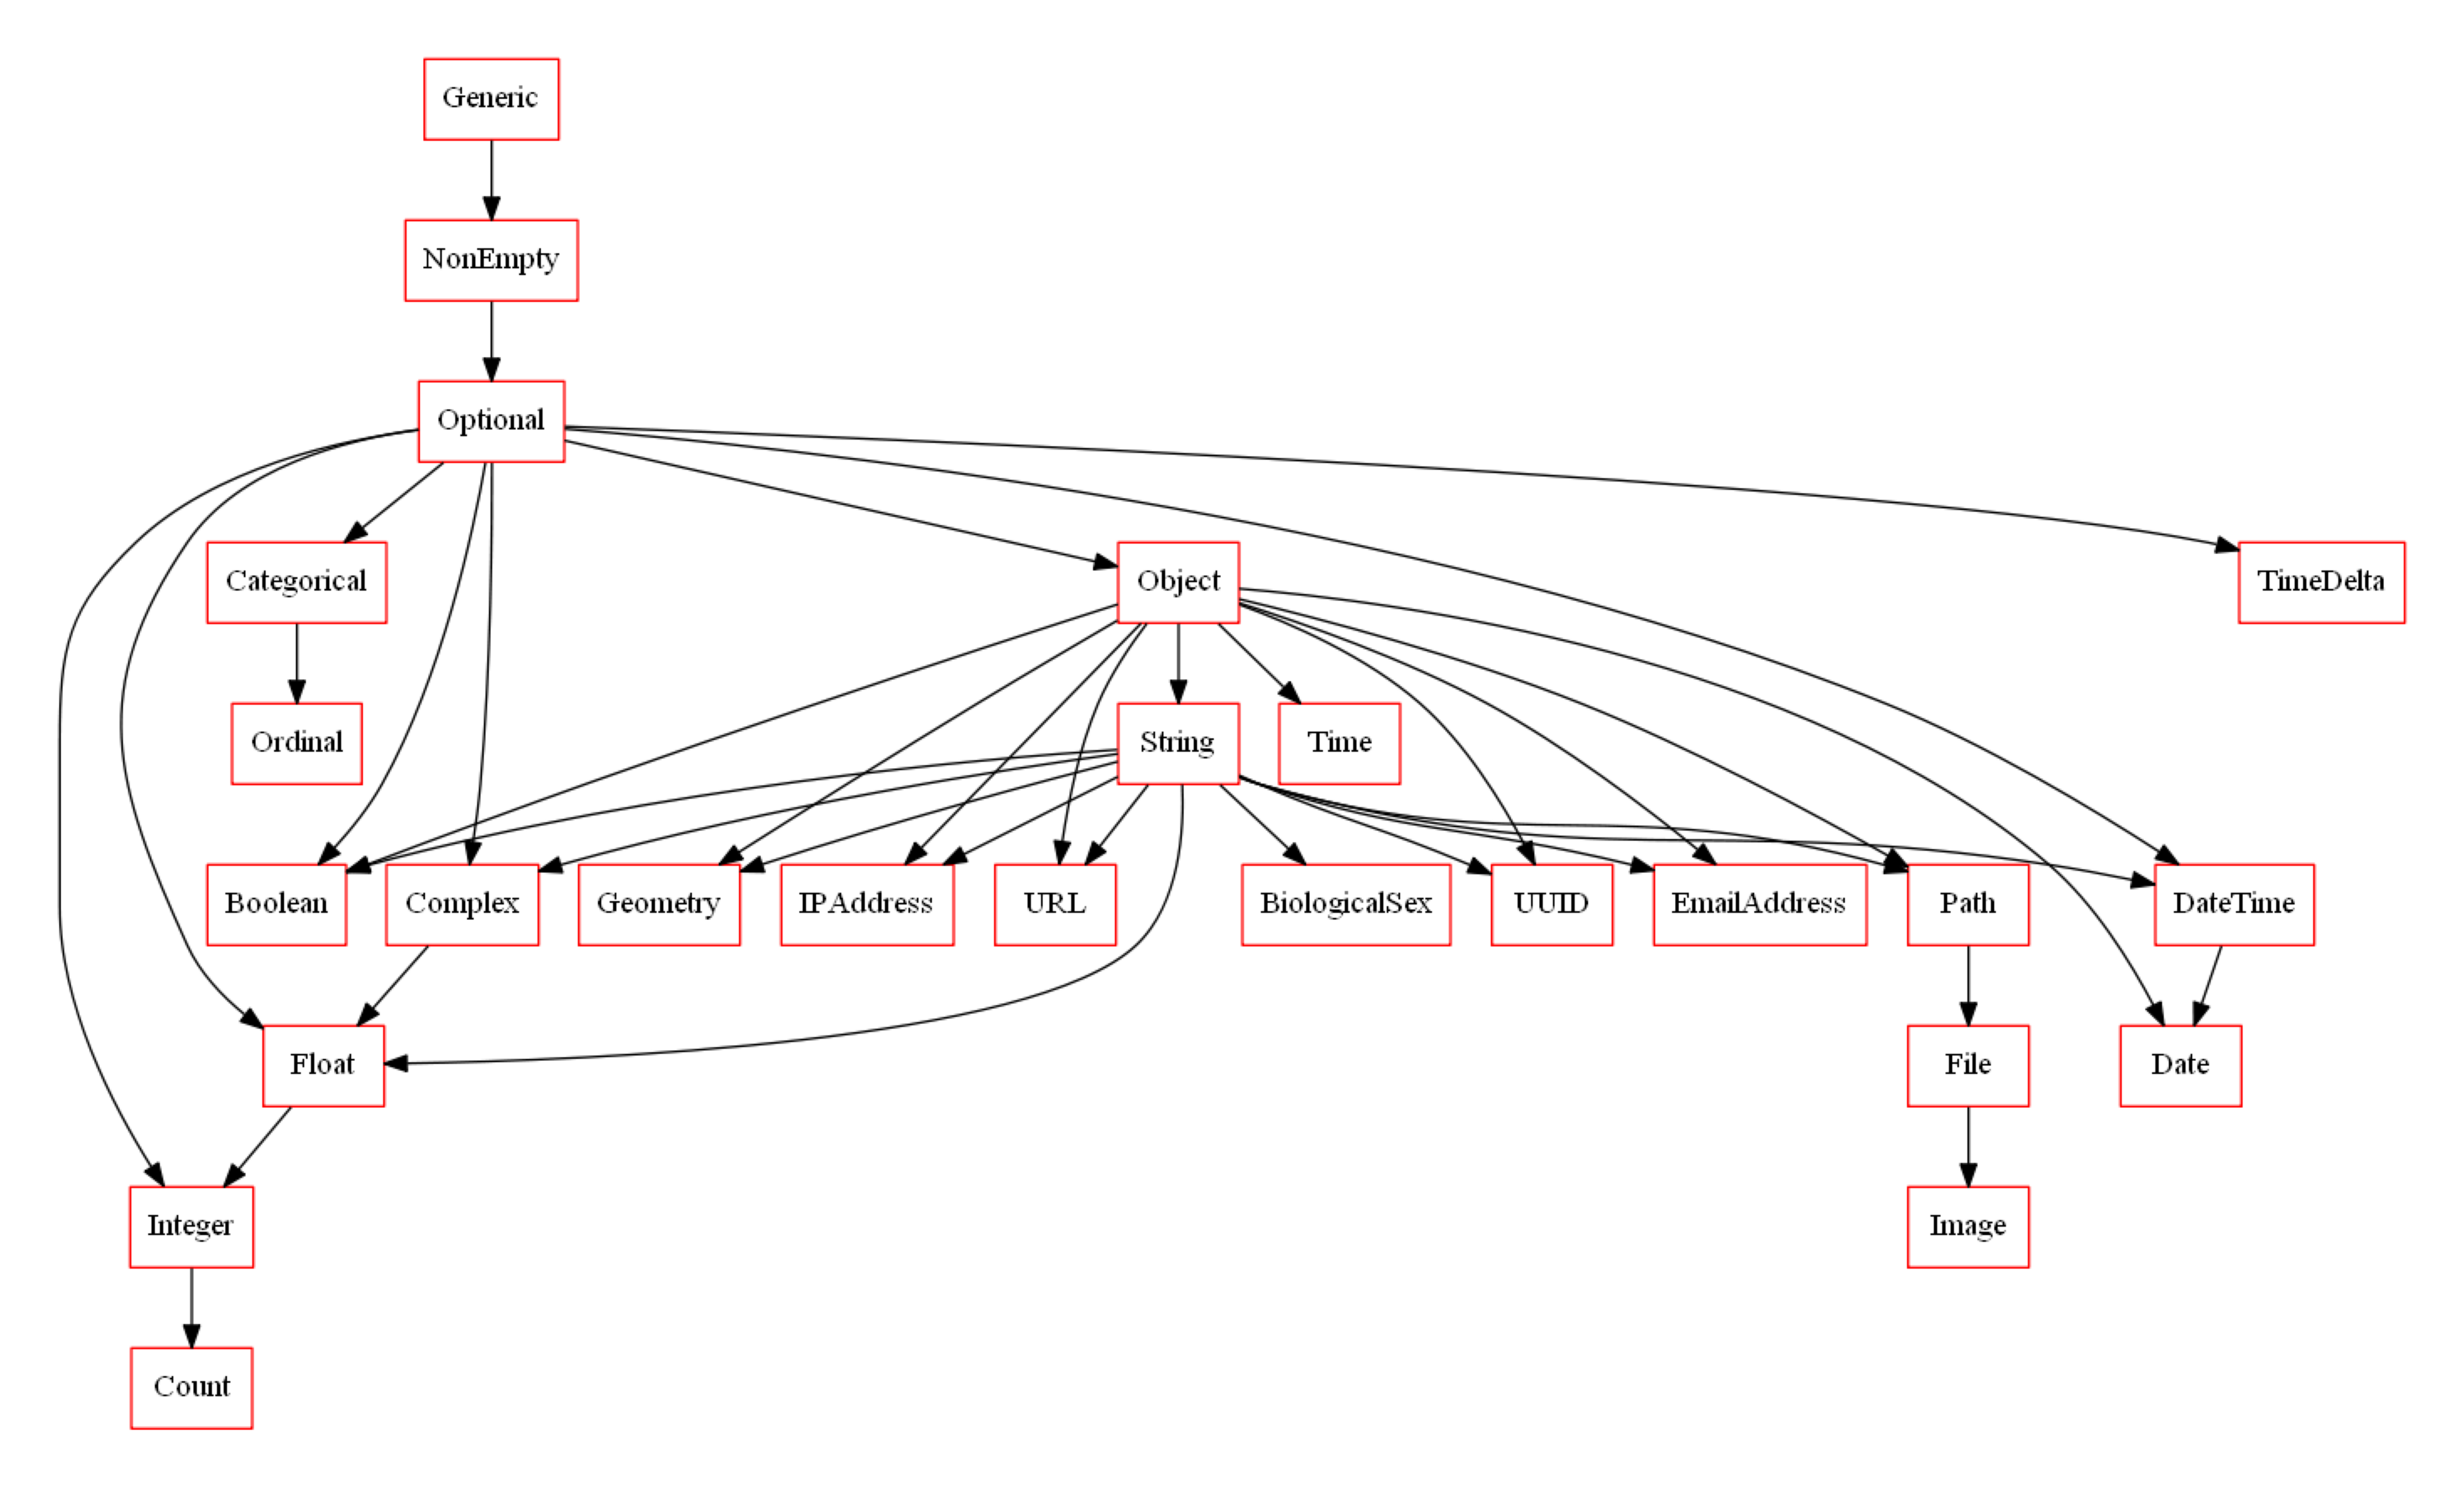

In [17]:
new_typeset = typeset + BiologicalSex
new_typeset.plot_graph()

# (1, 2, 3, 4)
# series = pd.Series([np.nan, 1.0, 2.0, 3.0], dtype=np.float)           
# state = {}

# new_series = pd.Series([1.0, 2.0, 3.0], dtype=np.float)
# state = {'hasnans': True}

# (2, 3, 4)
# new_series = pd.Series([1, 2, 3], dtype=pd.Int64Dtype)
# state = {'hasnans': True}
# path = [Generic, NonEmpty, Optional, Float, Integer]


# TODO: example with missing
def reconstitute_optional(new_series, series):
    # reconstitute
    new_series = new_series.reindex(series.index)
    new_series = pd.Series([pd.NA, 1, 2, 3], dtype=pd.Int64Dtype)



Voila, like that we have a new type appropriately inserted in the relationship graph of our new typeset and we can do all the same work done above.

# Dealing with Nulls

We do have one potential problem though, we haven't accounted for any missing value indicators in our `contains_op`, that means data with missing values won't be considered to be `BiologicalSex`. There are numerous ways to resolve this issue (should you wish) but `visions` offers utility functionality to easily define nullable contains operations.

We can even use both in the same typeset by appropriately defining relations.

In [18]:
# Invert narrative: nulls are accepted by default in this dataset.
null_biosex_series = pd.Series([np.nan, 'male', 'female']) 

null_biosex_series in BiologicalSex

True

In [24]:
class BiologicalSex(VisionsBaseType):
    @classmethod
    def contains_op(cls, series, data=dict()):
        return series.isin({'male', 'female'}).all()
    
    @classmethod
    def get_relations(cls):
        return [IdentityRelation(cls, String)]


class RequiredBiologicalSex(VisionsBaseType):
    @classmethod
    def contains_op(cls, series, data=dict()):
        # TODO: change signature in visions
        return series.isin({'male', 'female'}).all() and not data.get('hasnans', False)
    
    @classmethod
    def get_relations(cls):
        return [IdentityRelation(cls, BiologicalSex)]

In [25]:
# todo: always update typeset
new_typeset = typeset + RequiredBiologicalSex + BiologicalSex

In [26]:
null_biosex_series in RequiredBiologicalSex

True

In [27]:
null_biosex_series in BiologicalSex

True

# Bringing it all together

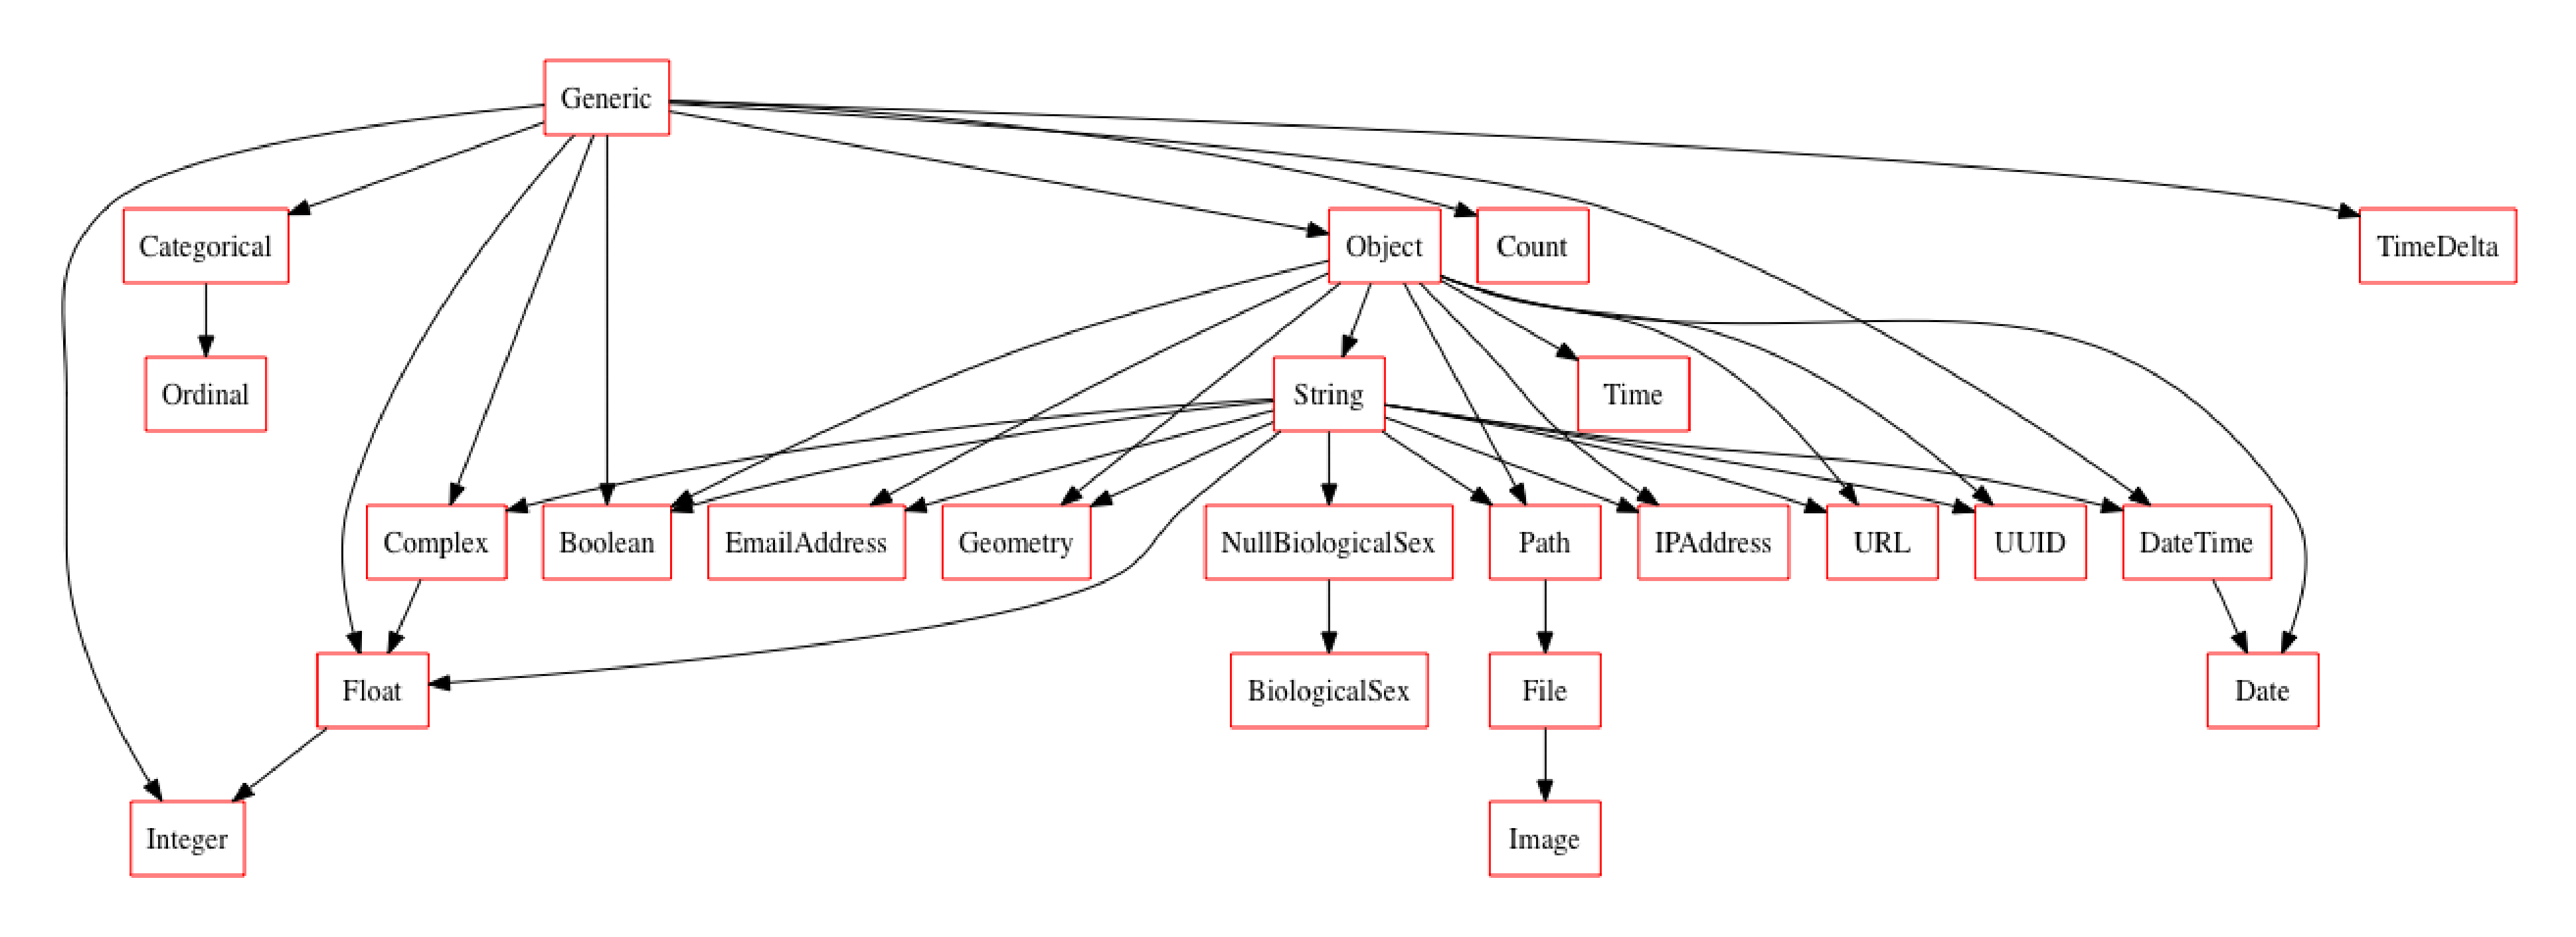

In [16]:
new_typeset = typeset + RequiredBiologicalSex + BiologicalSex
new_typeset.plot_graph()

In [17]:
import random

new_df = df.astype(str)
new_df['NullSex'] = [random.choice(['male', 'female', np.nan]) for i in range(df.shape[0])]

inferred_types = compare_detect_inference_frame(new_df, new_typeset)
pd.DataFrame({name: [data[i] for data in inferred_types] 
              for i, name in enumerate(['Columns', 'OriginalType', 'Inferredtype'])})

,Columns,OriginalType,Inferredtype
0,PassengerId,String,Integer
1,Age,String,Float
2,Fare,String,Float
3,NullSex,NullBiologicalSex,NullBiologicalSex
4,Survived,String,Integer
5,Embarked,String,String
6,Cabin,String,String
7,Name,String,String
8,Parch,String,Integer
9,Ticket,String,String
